# CS 109B - Course Project - Team 14
## Genre Prediction - IMDb - by Directors, Actors, Writers & Musicians

In [1]:
import sqlite3 
import re

import numpy as np
import os.path as op
import pandas as pd
import math 

from matplotlib import pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split as sk_split
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.io import mmwrite
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC

from IPython.display import display, HTML, Markdown
%matplotlib inline
plt.style.use('ggplot') 
def printmd(string):
    display(Markdown(string))

/Applications/Anaconda/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Applications/Anaconda/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
movie_fields = ['imdb_id',
                'Action','Adventure','Animation','Comedy','Crime','Documentary','Drama',
                'Family','Fantasy','History','Horror','Music','Mystery',
                'Romance','Sci-Fi','Thriller','War','Western']

genres = movie_fields[1:len(movie_fields)]

num_genres = len(genres)
num_non_genre_cols = 1

train_percent = 80

##import data

In [3]:
#import clean IMDB data

#ignore ,'Game-Show','News','Reality-TV', 'Biography','Adult','Film-Noir','Musical','Short','Sport','Talk-Show'
df_im = pd.read_csv( './datasets/output/imdb_movies_trim.csv'
                    , encoding='utf-8'
                    , usecols = movie_fields)
#reorder the columns
df_im = df_im[movie_fields]
#make genre names consistent with tmdb 
#df_im = df_im.rename(columns=['imdb_id'] + genres)

#import people (ignore name)
df_im_people = pd.read_csv('./datasets/output/imdb_people_trim.csv'
                           ,encoding='utf-8'
                           ,usecols = ['imdb_id','person_id','role_id'])
df_im_people.drop_duplicates(inplace=True)

In [4]:
# get overview of data
print
print("Data dimensions: " + str(df_im.shape))
display(df_im.head())


Data dimensions: (36007, 19)


,imdb_id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,114709,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,113497,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,113228,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,114885,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,113041,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
#function for plotting histograms
def plot_hist(data, title, x_label, face, axes, log=False):
    
    axes.hist(   data, 
                 50, 
                 normed=0, 
                 facecolor=face, 
                 alpha=0.75,
                 log = log
             )
    
    axes.set_title(title)
    axes.set_xlabel(x_label)
    str_y_label = 'frequency'
    if log:
        str_y_label = str_y_label + ' (log)'
    
    axes.set_ylabel(str_y_label)
    
    return axes

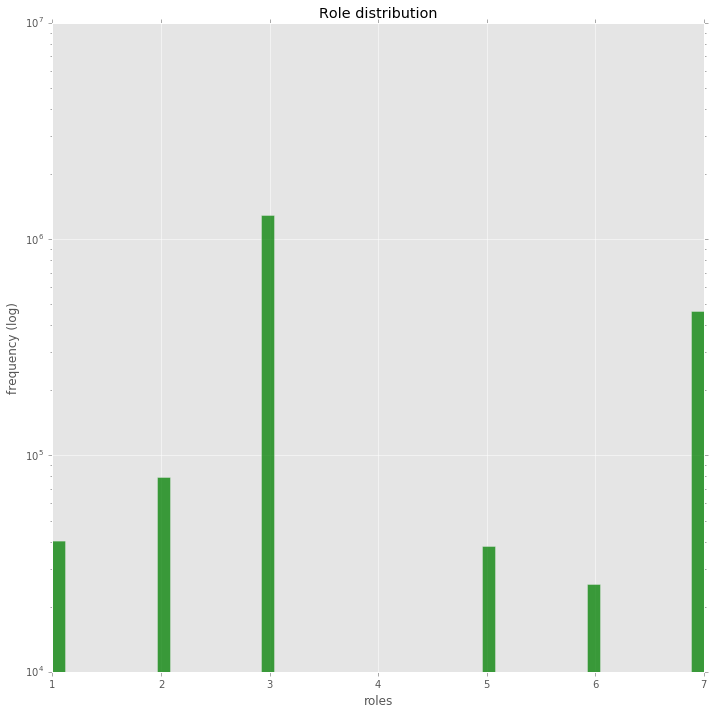

In [6]:
#plot histograms for each marker and each demographics
#in the following, instead of adding one subplot to a 4x2 grid at a time
#I can get all the subplot axes for the grid in one line 
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

ax1 = plot_hist(df_im_people['role_id'].values,
                'Role distribution', 
                'roles', 
                'green', 
                ax1, log = True)

plt.tight_layout()
plt.show()

For 36,000 movies we have around 2 million people/movie/role combinations. We need to get that down. Ae will start by filtering out some roles. While Actors is the bigest role we will keep it as we suspect it may be highly correlated to genre.

role_id	/ role

Use These Roles
- 1	director
- 2	writer
- 3	cast
- 5	original music

Ignore these Roles
- 4	production-manager
- 6	casting director
- 7	visual effects	

In [7]:
#write movie_people_role data to in-memory SQLite db for preprocessing
con = sqlite3.connect(":memory:")
#con.isolation_level = None
c = con.cursor()

df_im_people.to_sql('movie_people_role', con, index=False)
#df_im_people = None #Free up memory 

Get unique movie, person combinations

a person may have more then one role in the movie.   
Drop role and get distinct movie, person combination  
Consider only director,writer,cast and original music roles  

In [8]:
c.execute('Create table movie_people as                                ' + \
          'SELECT imdb_id, person_id                                   ' + \
          '   , count(*) as roles                                      ' + \
          '   , sum(CASE role_id WHEN 3 THEN 1 ELSE 0 END) as is_actor ' + \
          'FROM movie_people_role                                      ' + \
          'WHERE role_id in (1,2,3,5)'
          'GROUP BY imdb_id, person_id')

#index movie_people for better query optimisation
c.execute("CREATE UNIQUE INDEX IF NOT EXISTS pk_movie_person on movie_people (imdb_id, person_id)")
c.execute("CREATE UNIQUE INDEX IF NOT EXISTS person_movie    on movie_people (person_id,imdb_id)")

#Free up memory 
c.execute("DROP TABLE movie_people_role")

Count how many movies a person has been involved in and the number of roles

In [9]:
c.execute('Create table people as ' + \
          'SELECT DISTINCT person_id, count(imdb_id) as movies, sum(roles) as roles ' + \
          'FROM movie_people ' + \
          'GROUP BY person_id')

#index people for better query optimisation
c.execute("CREATE UNIQUE INDEX IF NOT EXISTS pk_person       on people (person_id)")
c.execute("CREATE INDEX IF NOT EXISTS person_movie_count     on people (movies, person_id)")

Look at the total number of movies a person is involved and the number of roles

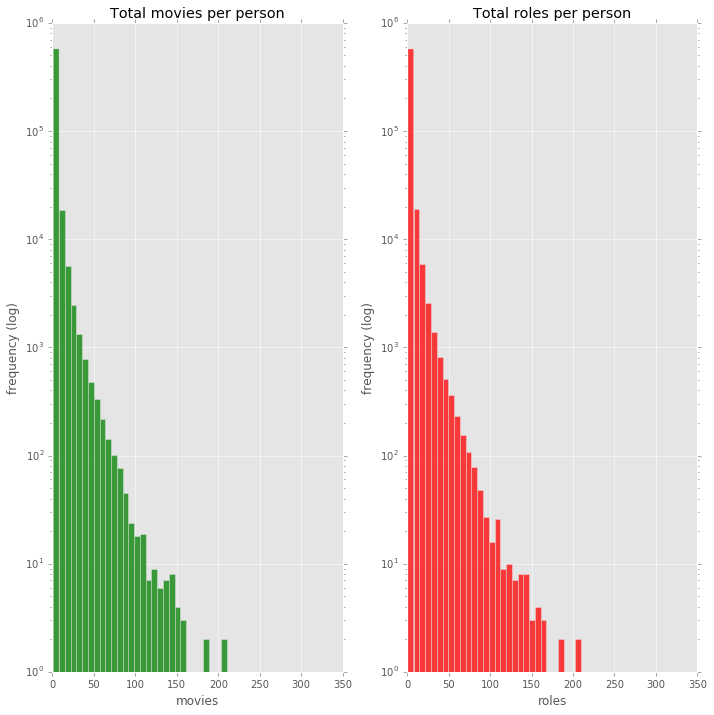

,movies,people,roles
0,36003,1420793,1453194


In [10]:
df_people = pd.read_sql('select * from people', con)

strsql =  'select   count(distinct imdb_id)   as movies   ' + \
          '       , count(*) as people                    ' + \
          '       , Sum(roles) as roles                   ' + \
          'from movie_people                              ' 
df_movies_count = pd.read_sql(strsql, con)


#plot histograms for each marker and each demographics
#in the following, instead of adding one subplot to a 4x2 grid at a time
#I can get all the subplot axes for the grid in one line 
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 10))

ax1 = plot_hist(df_people['movies'].values,
                'Total movies per person', 
                'movies', 
                'green', 
                ax1,
                log = True
               )

ax2 = plot_hist(df_people['roles'].values,
                'Total roles per person', 
                'roles', 
                'red', 
                ax2,
                log = True
               )

plt.yscale('log')                                   
plt.tight_layout()
plt.show()

df_movies_count

After filtering the roles, we still have 1.4 million people. The majority of people have been involved in only one or two movies. Selecting people who have been involved more than 10 movies reduced the number of people down to 419 thousand. The trade off is that it leaves ~2,00 movies with no people asigned to it.

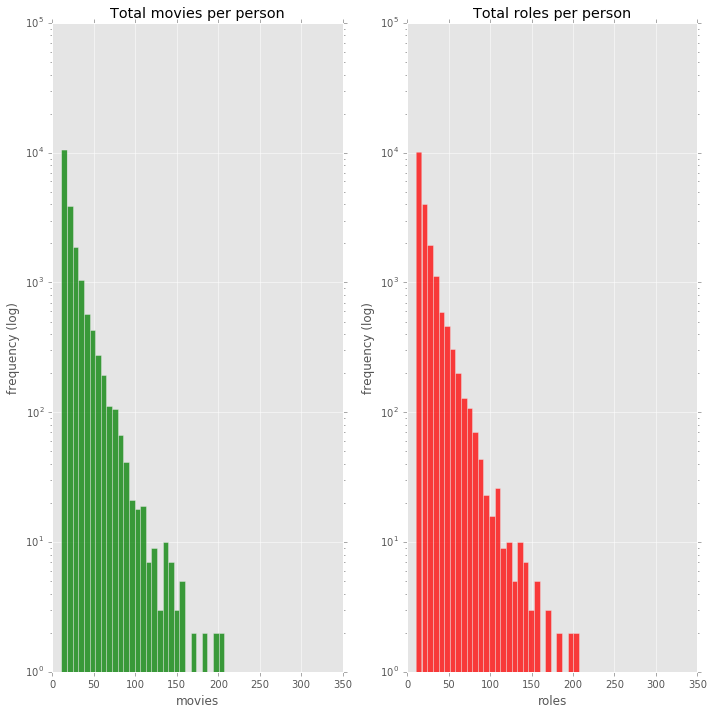

,movies,people,roles
0,32017,419060,429704


In [11]:
df_people = pd.read_sql('select * from people where movies > 10', con)

strsql =  'select count(distinct mp.imdb_id)   as movies ' + \
          '     , count(mp.person_id)          as people ' + \
          '     , sum(mp.roles)                as roles  ' + \
          'from people p                                 ' + \
          ' inner join movie_people mp                   ' + \
          '         on (p.person_id = mp.person_id)      ' + \
          'where p.movies > 10                           ' 

            
df_movies_count = pd.read_sql(strsql, con)

#plot histograms for each marker and each demographics
#in the following, instead of adding one subplot to a 4x2 grid at a time
#I can get all the subplot axes for the grid in one line 
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 10))

ax1 = plot_hist(df_people['movies'].values,
                'Total movies per person', 
                'movies', 
                'green', 
                ax1, 
                True)

ax2 = plot_hist(df_people['roles'].values,
                'Total roles per person', 
                'roles', 
                'red', 
                ax2, 
                True)

plt.tight_layout()
plt.show()

df_movies_count

Merge movie responses and people matrix

In [12]:
#extract the movie/people combinateions we are interested in
strsql =  'select mp.imdb_id     as imdb_id              ' + \
          '     , mp.person_id   as person_id            ' + \
          'from people p                                 ' + \
          ' inner join movie_people mp                   ' + \
          '         on (p.person_id = mp.person_id)      ' + \
          'where p.movies > 10                           ' 
df_people = pd.read_sql(strsql, con)

#pivot from stacked db list to 1 wide row per movie 
#columns now (imdb_id, person_1, person_2,...persion_n)
df_people_xt = pd.crosstab(df_people.imdb_id, df_people.person_id, margins=False)

#merge by movie_id to make sure the response and predictors align
df_people_xt['imdb_id_p'] = df_people_xt.index
data = pd.merge(left = df_im , right = df_people_xt, left_on='imdb_id', right_on='imdb_id_p')

#drop duplicate IMDB_id column
data = data.ix[:,:-2]

split into (x and y) and (test and train) 

In [13]:
#split into x (people) and y (genres)
y = data.ix[:,:len(df_im.columns)]
x = data.ix[:,len(df_im.columns):-1]

#split into test & train
n_samples = x.shape[0]
train = np.random.uniform(size=n_samples) > float(train_percent) / 100.

x_train = x[train]
y_train = y[train]

x_test = x[~train]
y_test = y[~train]

Apply TSVD to reduce predictors

In [14]:
# apply SVD to people matrix (train)
tsvd = tSVD(n_components = 100)
tsvd.fit(x_train)
x_train_pca = tsvd.transform(x_train)
print
print("Cumulative percentage of variance explained: " + \
      str(round(tsvd.explained_variance_ratio_.sum(), 4)))


Cumulative percentage of variance explained: 0.1197


In [15]:
pc1 = tsvd.components_[1]
pc1_top_loadings = np.where(pc1 > 10**-1.75)

In [16]:
# apply SVD to people matrix (test)
x_test_pca = tsvd.transform(x_test)

### Utility Functions

In [17]:
# define model codes
log_reg = 2
lda = 3
qda = 4
knn = 5
rfc = 6
boost = 7
svm = 8

In [18]:
# function to return name of model type
def get_model_name(model_type):
    if model_type == log_reg:
        model_name = "logistic regression"
    elif model_type == lda:
        model_name = "LDA"
    elif model_type == qda:
        model_name = "QDA"
    elif model_type == knn:
        model_name = "KNN"
    elif model_type == rfc:
        model_name = "random forests"
    elif model_type == boost:
        model_name = "boost"
    elif model_type == svm:
        model_name = "SVM"
    else:
        model_name = ""
        
    return model_name

In [19]:
# function to return unfitted model of given type
def get_model_instance(model_type, y):
    default_ratio = (y == 1).sum() / float(len(y))
    priors = (default_ratio, 1.0 - default_ratio)
    
    if model_type == log_reg:
         model_instance = Log_Reg(C = 1, class_weight = 'balanced', 
                                  n_jobs = 3)
    elif model_type == lda:
        model_instance = LDA(priors = priors)
    elif model_type == qda:
        model_instance = QDA(reg_param = 0.25)
    elif model_type == knn:
        model_instance = KNN(n_neighbors = 5)
    elif model_type == rfc:
        model_instance = RFC(n_estimators = 20, class_weight = 'balanced',
                            max_features = 'auto', max_depth = None, 
                             n_jobs = 3)
    elif model_type == boost:
        model_instance = Boost()
    elif model_type == svm:
        model_instance = SVC(kernel = 'poly', degree = 2, 
                             class_weight = 'balanced')
    else:
        model_instance = None
        
    return model_instance

In [20]:
# function to fit and score one model of given type
def cross_validate_one_model(x, y, model_type):
    np.random.seed(42)
        
    train_score_accum = 0
    test_score_accum = 0

    n_folds = 5
    kf = KFold(x.shape[0], n_folds = n_folds)
    for train_index, test_index in kf:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
  
        model = get_model_instance(model_type, y_train)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        
        train_score_accum += model.score(x_train, y_train)
        test_score_accum += model.score(x_test, y_test)

    # calculate accuracy
    train_score = train_score_accum / float(n_folds)
    test_score = test_score_accum / float(n_folds)
    
    return test_score

In [21]:
# function to fit and score one model of given type
def fit_and_score_one_model(x_train, y_train, x_test, y_test, model_type):
    np.random.seed(42)

    model = get_model_instance(model_type, y_train)
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)

    train_score = model.score(x_train, y_train)
    test_score  = model.score(x_test , y_test)
    
    return y_predict, test_score

### Modeling  
  
Each model below is fit on training data and then scored on testing data.  
  
#### Different Model Types  

In [22]:
model_types = [lda, log_reg, qda, rfc]
model_names = ['Linear Discriminant Analysis', 'Logistic Regression', \
               'Quadratic Discriminant Analysis', 'Random Forest Classifier']
num_model_types = len(model_types)
test_scores_models = np.zeros(num_model_types)

# fit and score model on each genre
for i in range(num_model_types):
    test_scores_models[i] = \
        cross_validate_one_model(x_train_pca, y_train.Action, 
                                 model_types[i])

In [23]:
test_scores_models_df = pd.DataFrame(test_scores_models, columns = ['Accuracy'])
test_scores_models_df.Accuracy = test_scores_models_df.Accuracy.round(2)
test_scores_models_df.index = model_names

print
printmd("Test Accuracy during Cross-Validation")
display(test_scores_models_df)

Test Accuracy during Cross-Validation

,Accuracy
Linear Discriminant Analysis,0.18
Logistic Regression,0.78
Quadratic Discriminant Analysis,0.85
Random Forest Classifier,0.86


#### Different Genre Types - Random Forest

In [24]:
y_predict_all_rf = np.zeros([y_test.shape[0], num_genres])
test_scores_all_rf = np.zeros(num_genres)

# fit and score model on each genre
for i in range(num_genres):
    y_predict_all_rf[:, i], test_scores_all_rf[i] = \
        fit_and_score_one_model(x_train_pca, 
                                y_train.iloc[:, i + num_non_genre_cols], 
                                x_test_pca, 
                                y_test.iloc[: , i + num_non_genre_cols], 
                                rfc)

In [25]:
test_scores_all_rf_df = pd.DataFrame(test_scores_all_rf, columns = ['Accuracy'])
test_scores_all_rf_df.Accuracy = test_scores_all_rf_df.Accuracy.round(2)
test_scores_all_rf_df.index = genres

print
printmd("Prediction Accuracy on Testing Data (with Random Forest)")
display(test_scores_all_rf_df)

Prediction Accuracy on Testing Data (with Random Forest)

,Accuracy
Action,0.86
Adventure,0.90
Animation,0.97
Comedy,0.70
Crime,0.85
Documentary,0.94
Drama,0.62
Family,0.94
Fantasy,0.92
History,0.95


In [26]:
avg_score_rf = test_scores_all_rf_df.Accuracy.mean()
printmd("")
printmd("The average test accuracy over all genres is " + \
        "{:.2f}".format(round(avg_score_rf, 2)))

The average test accuracy over all genres is 0.88

In [27]:
printmd("")
printmd("Description of Test Accuracy (with Random Forest)")
test_scores_all_rf_df.describe()

Description of Test Accuracy (with Random Forest)

,Accuracy
count,18.000000
mean,0.878333
std,0.097694
min,0.620000
25%,0.852500
50%,0.915000
75%,0.940000
max,0.970000


In [30]:
accu_all_rf = (y_predict_all_rf ==
            y_test.ix[:, num_non_genre_cols:(num_genres + num_non_genre_cols)])
per_movie_accu_rf = np.sum(accu_all_rf, axis = 1) / num_genres
avg_per_movie_accu_rf = per_movie_accu_rf.mean()

printmd("")
printmd("The average accuracy of Random Forests predicting multiple genres per movie is " + \
      "{:.2f}".format(round(avg_per_movie_accu_rf, 2)))

The average accuracy of Random Forests predicting multiple genres per movie is 0.88

#### Different Genre Types - QDA

In [31]:
y_predict_all_qda = np.zeros([y_test.shape[0], num_genres])
test_scores_all_qda = np.zeros(num_genres)

# fit and score model on each genre
for i in range(num_genres):
    y_predict_all_qda[:, i], test_scores_all_qda[i] = \
        fit_and_score_one_model(x_train_pca, 
                                y_train.iloc[:, i + num_non_genre_cols], 
                                x_test_pca, 
                                y_test.iloc[: , i + num_non_genre_cols], 
                                qda)

In [33]:
test_scores_all_qda_df = pd.DataFrame(test_scores_all_qda, columns = ['Accuracy'])
test_scores_all_qda_df.Accuracy = test_scores_all_qda_df.Accuracy.round(2)
test_scores_all_qda_df.index = genres

print
printmd("Prediction Accuracy on Testing Data (with QDA)")
display(test_scores_all_qda_df)

Prediction Accuracy on Testing Data (with QDA)

,Accuracy
Action,0.85
Adventure,0.89
Animation,0.96
Comedy,0.66
Crime,0.85
Documentary,0.94
Drama,0.49
Family,0.93
Fantasy,0.93
History,0.96


In [34]:
avg_score_qda = test_scores_all_qda_df.Accuracy.mean()
printmd("")
printmd("The average test accuracy over all genres is " + \
        "{:.2f}".format(round(avg_score_qda, 2)))

The average test accuracy over all genres is 0.87

In [35]:
printmd("")
printmd("Description of Test Accuracy (with QDA)")
test_scores_all_qda_df.describe()

Description of Test Accuracy (with QDA)

,Accuracy
count,18.000000
mean,0.870000
std,0.123479
min,0.490000
25%,0.850000
50%,0.920000
75%,0.947500
max,0.970000


In [37]:
accu_all_qda = (y_predict_all_qda ==
            y_test.ix[:, num_non_genre_cols:(num_genres + num_non_genre_cols)])
per_movie_accu_qda = np.sum(accu_all_qda, axis = 1) / num_genres
avg_per_movie_accu_qda = per_movie_accu_qda.mean()

printmd("")
printmd("The average accuracy of predicting multiple genres per movie is " + \
      "{:.2f}".format(round(avg_per_movie_accu_qda, 2)))

The average accuracy of predicting multiple genres per movie is 0.87

#### Comparing Accuracy with Random Forest and QDA

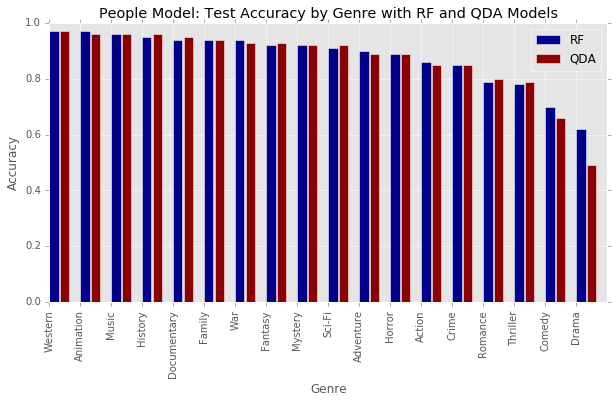

In [39]:
### plot genre accuracy for RF vs. QDA
test_scores_all_rf_df = test_scores_all_rf_df.sort_values(by = 'Accuracy', ascending = False)
test_scores_all_qda_df = test_scores_all_qda_df.sort_values(by = 'Accuracy', ascending = False)

width = 0.3

print
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
rects_1 = ax.bar(range(num_genres), 
       test_scores_all_rf_df.Accuracy, width = width, color = 'darkblue', 
       edgecolor = 'white')
rects_2 = ax.bar(np.repeat(0.35, num_genres) + range(num_genres), 
       test_scores_all_qda_df.Accuracy, width = width, color = 'darkred', 
       edgecolor = 'white')
ax.set_xticks(range(num_genres))
ax.set_xticklabels(test_scores_all_rf_df.index.values, rotation = 90)
ax.set_xlabel("Genre")
ax.set_ylabel("Accuracy")
ax.set_title("People Model: Test Accuracy by Genre with RF and QDA Models")
ax.legend((rects_1[0], rects_2[0]), ('RF', 'QDA'))
plt.show()